In [1]:
from importlib.metadata import version
import torch

print("TORCH VERSION :", version("torch"))
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backend.mps.is_available() else "cpu"
)
print("GPU  : ", device.upper())

torch.manual_seed(123)
torch.cuda.manual_seed(123)

TORCH VERSION : 2.2.2
GPU  :  CUDA


In [2]:
import datasets

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from contextlib import nullcontext

from src.tokenize.tokenizer import Tokenizer

In [3]:
TOKENIZER_CHECKPOINT = (
    "/home/pranav-pc/projects/OpenTransformer/multiformer/tokenizer_checkpoints/"
)

In [4]:
# ix = torch.randint(10000 - 1024, (64,))
# x = torch.stack([data[i:i+block_size] for i in ix])
# y = torch.stack([data[i+1:i+block_size+1] for i in ix])

### Load Data

In [5]:
# Load dataset from Hugging Face datasets library
from datasets import load_dataset

dataset = load_dataset("imdb")

### EDA

<Axes: ylabel='Count'>

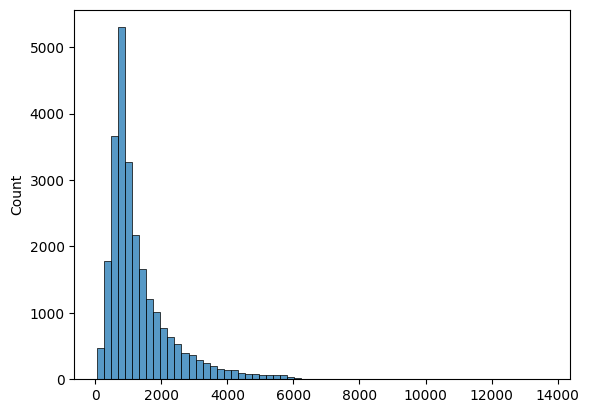

In [6]:
import seaborn as sns

sns.histplot([len(t) for t in dataset["train"]["text"]], bins=64)

### Pre-Process

In [7]:
tokenizer = Tokenizer(TOKENIZER_CHECKPOINT)

data = dataset.map(
    lambda example: {"idx": [en[:1024] for en in tokenizer.encode(example["text"])]},
    batch_size=512,
    batched=True,
    remove_columns=dataset["train"].column_names,
)
data

DatasetDict({
    train: Dataset({
        features: ['idx'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['idx'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['idx'],
        num_rows: 50000
    })
})

In [8]:
# Define collate function to handle padding
def collate_fn(batch):
    x_batch = [torch.tensor(en[:-1]) for en in batch]  # Extract x (remove last token)
    y_batch = [torch.tensor(en[1:]) for en in batch]  # Extract y (remove first token)
    x_padded = pad_sequence(
        x_batch, batch_first=True, padding_value=tokenizer.eos_id()
    )  # Pad x sequences
    y_padded = pad_sequence(
        y_batch, batch_first=True, padding_value=tokenizer.eos_id()
    )  # Pad y sequences
    return x_padded, y_padded


# Sort the data and turn off shuffle - Simplest way of implementing Seq leng batch sampling
train_data = sorted(data["train"]["idx"], key=lambda x: len(x))

# Create DataLoader with collate function
train_loader = DataLoader(
    train_data, batch_size=64, collate_fn=collate_fn, shuffle=False
)

In [9]:
for i, (x, y) in enumerate(train_loader):
    print(x, y)
    break

    if i == 4:
        break

tensor([[    1,   910, 14064,  ...,     2,     2,     2],
        [    1,   306,  7656,  ...,     2,     2,     2],
        [    1,   887, 29915,  ...,     2,     2,     2],
        ...,
        [    1,   306,   925,  ...,   292, 29991,     2],
        [    1,   910, 14064,  ..., 29879, 29889,     2],
        [    1,   315,  1507,  ...,  3578,  1076, 29889]]) tensor([[  910, 14064,   338,  ...,     2,     2,     2],
        [  306,  7656, 29915,  ...,     2,     2,     2],
        [  887, 29915, 29881,  ...,     2,     2,     2],
        ...,
        [  306,   925, 20654,  ..., 29991,     2,     2],
        [  910, 14064,   338,  ..., 29889,     2,     2],
        [  315,  1507,  2969,  ...,  1076, 29889,     2]])


#### Q : Should I reshuffle the data loader to present inputs with varying sizes randomly rather than in a specific order?

In [10]:
from src.models.gpt2.config import GPT2Config
from src.models.gpt2.model import GPT2

TORCH VERSION : 2.2.2
Device  :  CUDA


In [11]:
conf = {
    "block_size": 1024,
    "vocab_size": tokenizer.vocab_size(),
    "n_layer": 4,
    "n_head": 12,
    "n_embd": 768,
    "dropout": 0.0,
    "bias": True,
    "device": device,
}

In [12]:
config = GPT2Config(**conf)
model = GPT2(config)

number of parameters: 52.92M


In [13]:
ctx = (
    nullcontext()
    if device == "cpu"
    else torch.amp.autocast(device_type=device, dtype=torch.bfloat16)
)

In [22]:
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer for logging
writer = SummaryWriter(log_dir="gpt2_log")

In [23]:
from src.cells.optim_func import configure_optimizers

optimizer = configure_optimizers(
    model,
    weight_decay=1e-2,
    learning_rate=1e-4,
    betas=(0.9, 0.95),
    device=device,
    fused=True,
)
model.to(device)
model = torch.compile(model)

num decayed parameter tensors: 18, with 53,673,984 parameters
num non-decayed parameter tensors: 16, with 27,648 parameters
using fused AdamW: True


In [24]:
import torch._dynamo

torch._dynamo.config.suppress_errors = True

In [26]:
import torch.autograd.profiler as profiler

In [ ]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    total_loss = 0

    # Start Torch Profiler
    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        # schedule=torch.profiler.schedule(
        #     wait=wait, warmup=warmup, active=active, repeat=1
        # ),
        on_trace_ready=torch.profiler.tensorboard_trace_handler("./gpt2_log"),
        record_shapes=True,
        profile_memory=True,
        with_stack=False,  # incurs an additional overhead, disable if not needed
        with_flops=True,
        with_modules=False,  # only for torchscript models atm
    ) as prof:
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            logits, loss = model(x, y)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

            # Log loss to TensorBoard
            writer.add_scalar(
                "Loss/train", loss.item(), epoch * len(train_loader) + batch_idx
            )

            # Print statement after every 100 iterations
            if (batch_idx + 1) % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], Iteration [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}"
                )

    # Average loss calculation
    average_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    # Save model after every epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")

# Close the TensorBoard writer
writer.close()

STAGE:2024-03-30 16:40:29 249805:249805 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[2024-03-30 16:41:04,475] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2024-03-30 16:41:04,475] torch._dynamo.convert_frame: [WARNING]    function: 'forward' (/home/pranav-pc/.env/lib/python3.11/site-packages/src/models/gpt2/block.py:20)
[2024-03-30 16:41:04,475] torch._dynamo.convert_frame: [WARNING]    last reason: ___compile_config_hash() == '7cff654352af5cadf3ad4cc85f581810'  # _dynamo/output_graph.py:387 in init_ambient_guards
[2024-03-30 16:41:04,475] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2024-03-30 16:41:04,475] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.
[2024-03-30 16:41:07,381] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2024-03-30 16:41: